In [24]:
!pip install amplpy pyomo -q
!python -m amplpy.modules install coin highs scip gcg -q

# Proyecto Senecalibre - Parte 2

Autores:
David Alejandro Fuquen Flórez - 202021113
Juan Diego Sarmiento Sáncehz - 202121484

A continuación se crean las funciones y clases generales para todos los casos. Con la función Data_tranformation() se transforman los datos de los CSV a las estructuras de datos deseadas según el caso. Los parámetros son el nombre del archivo con información de los vehículos, el nombre del archivo con la información de los depots, el nombre del archivo con la información de los depots (si hay, si no puede colocarse "no_depot") y el caso seleccionado, que puede ser un entero igual a 1, 2, 3, 4.

Así mismo tenemos una clase display_graphs con la que se pueden visualizar los grafos resultantes del modelo.

Finalmente, tenemos la función de costos que se llama generate_total_costs que genera los costos del modelo.

In [25]:
from __future__ import division
from pyomo.environ import *
import pandas  as pd
from pyomo.opt import SolverFactory
import networkx as nx
from matplotlib import pyplot as plt
from amplpy import modules
from pyomo.util.model_size import build_model_size_report
import math
import pandas as pd
import numpy as np
import requests
import networkx as nx
import matplotlib.pyplot as plt



In [26]:
def Data_transformation(path_to_vehicles, path_to_depots, path_to_clients, path_to_depot_capacity, case_selection):
    gas_cars = {
        "Vehicle": "Gas Car",
        "Freight Rate [COP/km]": 5000,
        "Time Rate [COP/min]": 500,
        "Daily Maintenance [COP/day]": 30000,
        "Recharge/Fuel Cost [COP/(gal or kWh)]": 16000,
        "Recharge/Fuel Time [min/10 percent charge]": 0.1,
        "Avg. Speed [km/h]": None,
        "Gas Efficiency [km/gal]": 10,
    }

    # Data for Drones
    drones = {
        "Vehicle": "Drone",
        "Freight Rate [COP/km]": 500,
        "Time Rate [COP/min]": 500,
        "Daily Maintenance [COP/day]": 3000,
        "Recharge/Fuel Cost [COP/(gal or kWh)]": 220.73,
        "Recharge/Fuel Time [min/10 percent charge]": 2,
        "Avg. Speed [km/h]": 40,
        "Gas Efficiency [km/gal]": None,
        "Electricity Efficency [kWh/km]": 0.15,
    }


    # Data for Solar EVs
    solar_ev = {
        "Vehicle": "Solar EV",
        "Freight Rate [COP/km]": 4000,
        "Time Rate [COP/min]": 500,
        "Daily Maintenance [COP/day]": 21000,
        "Recharge/Fuel Cost [COP/(gal or kWh)]": None,
        "Recharge/Fuel Time [min/10 percent charge]": None,
        "Avg. Speed [km/h]": None,
        "Gas Efficiency [km/gal]": None,
        "Electricity Efficency [kWh/km]": 0.15,
    }



    depots_df = pd.read_csv(path_to_depots)
    clients_df = pd.read_csv(path_to_clients)

    if case_selection == 3:
        depots_capacity_df = pd.read_csv(path_to_depot_capacity)
        depots_df = depots_df.merge(depots_capacity_df[['DepotID', 'Product']], on='DepotID', how='left')

    if case_selection == 4:
        clients_df['Product'] = clients_df['Product-Type-A'] + clients_df['Product-Type-B'] + clients_df['Product-Type-C']



    #depots_df = pd.read_csv('smalldepots.csv')
    #clients_df = pd.read_csv('smallclients.csv')

    # extract coordinates
    depots_coords = depots_df[['Longitude', 'Latitude']].values.tolist()
    clients_coords = clients_df[['Longitude', 'Latitude']].values.tolist()

    # Combine depots and clients
    all_coords = depots_coords + clients_coords

    # Build the coordinates string for OSRM
    coords_str = ';'.join([f"{lon},{lat}" for lon, lat in all_coords])




    # API URL
    url = f"https://router.project-osrm.org/table/v1/driving/{coords_str}"

    # Parameters
    params = {
        'sources': ';'.join(map(str, range(len(all_coords)))),
        'destinations': ';'.join(map(str, range(len(all_coords)))),
        'annotations': 'duration,distance'
    }

    # Send the request
    response = requests.get(url, params=params)

    # Check for successful response
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        print(response.text)
        exit()

    data = response.json()

    # Extract the distance matrix
    car_matrix_distance = np.array(data['distances'])
    car_matrix_distance = car_matrix_distance / 1000

    #The distance matrix gives the distance in km from node i to node j.

    # Extract the duration matrix
    car_matrix_time = np.array(data['durations'])
    car_matrix_time = car_matrix_time / 60

    #The duration matrix gives the time in minutes from node i to node j.




    def haversine(lon1, lat1, lon2, lat2):

        lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

        # haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
        return c * r

    nodes = all_coords

    drone_matrix = [[0 for _ in range(len(nodes))] for _ in range(len(nodes))]
    #The drone matrix gives the distance in km from node i to node j if a drone is used.

    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if i != j:
                origin = nodes[i]
                destination = nodes[j]
                origin_latitud = origin[1]
                origin_longitud = origin[0]
                destination_latitud = destination[1]
                destination_longitud = destination[0]
                drone_matrix[i][j] = haversine(origin_longitud, origin_latitud, destination_longitud, destination_latitud)

    drone_matrix_distance = np.array(drone_matrix)

    drone_matrix_time = drone_matrix_distance / drones["Avg. Speed [km/h]"]
    drone_matrix_time = drone_matrix_time * 60

    #No cars anc clients no more. We gonna use dataframes


    cars_df = pd.read_csv(path_to_vehicles)

    num_depots = len(depots_coords)

    depots_df["LocationID"] = depots_df["LocationID"] - 1
    clients_df["LocationID"] = clients_df["LocationID"] - 1

    first_client = clients_df["LocationID"].iloc[0]
    last_client = clients_df["LocationID"].iloc[-1]



    np.fill_diagonal(car_matrix_distance, 9999999)
    np.fill_diagonal(car_matrix_time, 9999999)
    np.fill_diagonal(drone_matrix_distance, 9999999)
    np.fill_diagonal(drone_matrix_time, 9999999)




    num_cars = len(cars_df)

    return gas_cars, drones, solar_ev, car_matrix_distance, car_matrix_time, drone_matrix_distance, drone_matrix_time, cars_df, clients_df, num_depots, first_client, last_client, num_cars, depots_df








In [27]:
from __future__ import division
from pyomo.environ import *
import pandas  as pd
from pyomo.opt import SolverFactory
import networkx as nx
from matplotlib import pyplot as plt
from amplpy import modules
from pyomo.util.model_size import build_model_size_report

class BaseCase:
    def __init__(self, data):
        """
        Initialize the model parameters.
        """
        self.gas_cars = data[0]
        self.drones = data[1]
        self.solar_ev = data[2]
        self.car_matrix_distance = data[3]
        self.car_matrix_time = data[4]
        self.drone_matrix_distance = data[5]
        self.drone_matrix_time = data[6]
        self.cars = data[7]
        self.clients = data[8]
        self.num_depots = data[9]
        self.first_client = data[10]
        self.last_client = data[11]
        self.num_cars = data[12]
        self.depots_df = data[13]


        # Create the Pyomo model
        self.model = ConcreteModel()

    def build_model(self):
        """
        Build the optimization model.
        """
        model = self.model

        # Sets
        model.depots_set = RangeSet(0, self.num_depots-1) #Set of depots. In the cost_matrix, the depots come first
        model.clients_set = RangeSet(self.first_client, self.last_client) #Set of clients. In the cost matrix, the clients come after the depots.
        model.nodes = RangeSet(0, self.last_client) #Set of nodes. This includes both depots and clients.
        model.cars_set = RangeSet(0, self.num_cars-1) #Set of vehicles.


        #Decision Variables
        model.x = Var(model.nodes, model.nodes, model.cars_set, domain=Binary)
        model.u = Var(model.clients_set, model.cars_set, domain=NonNegativeReals, bounds = (0, len(model.nodes)-1))




        # Objective: Minimize total cost (energy, installation, and communication costs)
        def obj_expression(model):
            cost1 = 0
            for k in model.cars_set:
                cost1 += sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)*500
            #Revised with JD

            #Cost of driving the car (distance)
            cost2 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars['VehicleType'].iloc[k] == "Gas Car":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.gas_cars["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost2 += self.drone_matrix_distance[i][j]*model.x[i,j,k]*self.drones["Freight Rate [COP/km]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost2 += self.car_matrix_distance[i][j]*model.x[i,j,k]*self.solar_ev["Freight Rate [COP/km]"]
            #Revised with JD

            #Cost of driving the car (time)
            cost3 = 0
            for i in model.nodes:
                for j in model.nodes:
                    for k in model.cars_set:
                        if self.cars["VehicleType"].iloc[k] == "Gas Car":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.gas_cars["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "drone":
                            cost3 += self.drone_matrix_time[i][j]*model.x[i,j,k]*self.drones["Time Rate [COP/min]"]
                        elif self.cars["VehicleType"].iloc[k] == "EV":
                            cost3 += self.car_matrix_time[i][j]*model.x[i,j,k]*self.solar_ev["Time Rate [COP/min]"]
            #Revised with JD

            #Cost for gas
            cost4 = 0
            for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost4 += self.gas_cars["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.gas_cars["Gas Efficiency [km/gal]"])
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost4 += self.drones["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes) / self.drones["Electricity Efficency [kWh/km]"])
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost4 += 0
            #Revised with JD

            #Cost for maintenance
            cost5 = 0
            '''for k in model.cars_set:
                if self.cars["VehicleType"].iloc[k] == "Gas Car":
                    cost5 += self.gas_cars["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "drone":
                    cost5 += self.drones["Daily Maintenance [COP/day]"]
                elif self.cars["VehicleType"].iloc[k] == "EV":
                    cost5 += self.solar_ev["Daily Maintenance [COP/day]"]'''
            #Revised with JD, he propose to use it as a constant

            return cost1 + cost2 + cost3 + cost4 + cost5

        model.obj = Objective(rule=obj_expression, sense=minimize)

        #Constraint 1: Vehicle Flow Conservation: Ensure that each vehicle entering a node also leaves the node if the node is a client:
        def restriccion_1(model, j, k):
                return sum(model.x[i,j,k] for i in model.nodes) - sum(model.x[j,i,k] for i in model.nodes) == 0
        model.restriccion_1 = Constraint(model.clients_set, model.cars_set, rule = restriccion_1)



        def restriccion_2(model, j):
            return sum(model.x[i,j,k] for i in model.nodes for k in model.cars_set) == 1
        model.restriccion_2 = Constraint(model.clients_set,  rule = restriccion_2)

        #Constraint 3_1: Vehicles end in any depot
        def restriccion_3_1(model, k):
            return sum(model.x[i,j,k] for j in model.depots_set for i in model.nodes) == 1
        model.restriccion_3_1 = Constraint(model.cars_set, rule = restriccion_3_1)

        #Constraint 3_2: Vehicles start in any depot
        def restriccion_3_2(model, k):
            return sum(model.x[i,j,k] for i in model.depots_set for j in model.nodes) == 1
        model.restriccion_3_2 = Constraint(model.cars_set, rule = restriccion_3_2)

        def restriccion_5(model, i, j, k):
            if i != j:
                return model.u[i,k] - model.u[j,k] + len(model.clients_set)*model.x[i,j,k] <= len(model.clients_set)-1
            else:
                return Constraint.Skip
        model.restriccion_5 = Constraint(model.clients_set, model.clients_set, model.cars_set, rule = restriccion_5)




        #Constraint 4: Vehicle capacity must be bigger than the demand of the clients
        def restriccion_4(model, k):
            return sum(model.x[i,j,k]*self.clients.loc[self.clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set) <= self.cars["Capacity"].iloc[k]
        model.restriccion_4 = Constraint(model.cars_set, rule = restriccion_4)



        #Constraint 6: Each car should have enough range to visit all the clients
        def restriccion_6(model, k):
            if self.cars["VehicleType"].iloc[k] == "EV" or self.cars["VehicleType"].iloc[k] == "Gas Car":
                return self.cars["Range"].iloc[k] >= sum(self.car_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
            elif self.cars["VehicleType"].iloc[k] == "drone":
                return self.cars["Range"][k] >= sum(self.drone_matrix_distance[i][j]*model.x[i,j,k] for i in model.nodes for j in model.nodes)
        model.restriccion_6 = Constraint(model.cars_set, rule = restriccion_6)

        #Cannot travel from depot to depot directly
        def restriccion_7(model, i, j, k):
            return model.x[i,j,k] == 0
        model.restriccion_7 = Constraint(model.depots_set, model.depots_set, model.cars_set, rule = restriccion_7)





        return model

    def solve_model(self):
        solver_name = "highs"
        solver = SolverFactory(solver_name+"nl", executable=modules.find(solver_name), solve_io="nl")
        #solver.options['parallel'] = 'on'
        solver.options['time_limit'] = 3600  # 1-hour time limit
        #solver.options['presolve'] = 'on'
        #solver.options['mip_rel_gap'] = 0.01  # 1% relative gap
        #solver.options['simplex_strategy'] = 1  # Dual simplex
        #solver.options['simplex_max_concurrency'] = 8  # Max concurrency
        #solver.options['mip_min_logging_interval'] = 10  # Log every 10 seconds
        #solver.options['mip_heuristic_effort'] = 0.2  # Increase heuristic effort

        result = solver.solve(self.model, tee=True)

        # Check solver status
        if result.solver.termination_condition == TerminationCondition.optimal:
            print("Optimal solution found.")
        elif result.solver.termination_condition == TerminationCondition.maxTimeLimit:
            print("Time limit reached, solution may be suboptimal.")
        else:
            print(f"Solver terminated with condition: {result.solver.termination_condition}")

        print(result)
        """
        Solve the model using the given solver.
        """
        return result

    def display_results(self):
        """
        Display the results of the optimization.
        """
        self.model.display()
    def print_output(self):
        """
        Plot sensor placement solutions on directed graphs using NetworkX for each sensor type in a subplot.
        """
        pass




# Caso 1
A continuación tenemos el caso 1.

In [28]:
data = Data_transformation('Vehicles.csv', 'Depots.csv', 'Clients.csv', 'Nope', 1)

base_case = BaseCase(data)

base_case.build_model()

base_case.solve_model()

HiGHS 1.8.1:   lim:time = 3600
Optimal solution found.

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 8712
  Number of variables: 15840
  Sense: unknown
Solver: 
- Status: ok
  Message: HiGHS 1.8.1\x3a optimal solution; objective 762359.290741627; 131367 simplex iterations; 384 branching nodes; absmipgap=74.3366, relmipgap=9.75086e-05
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 94.15167450904846
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 8712, 'Number of variables': 15840, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'HiGHS 1.8.1\\x3a optimal solution; objective 762359.290741627; 131367 simplex iterations; 384 branching nodes; absmipgap=74.3366, relmipgap=9.75086e-05', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 94.15167450904846}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Ahora, veremos los costos relacionados con el Caso 1. Pero antes, podemos ver la función general que nos servirá para todos los casos.

In [29]:
import datetime
import pandas as pd

def generate_total_costs(model,clients,car_matrix_distance,
                         drone_matrix_distance,gas_cars,drones
                         ,solar_ev,cars,car_matrix_time,drone_matrix_time):
    #Costo por Kg cargado total.
    cost1 = 0
    for k in model.cars_set:
        cost1 += sum(model.x[i,j,k].value*clients.loc[clients['LocationID'] == j, 'Product'].iloc[0] for i in model.nodes for j in model.clients_set)*500

    #Costo por distancia recorrida de vehiculo total.
    cost2 = 0
    for i in model.nodes:
        for j in model.nodes:
           for k in model.cars_set:
            if cars['VehicleType'].iloc[k] == "Gas Car":
                cost2 += car_matrix_distance[i][j]*model.x[i,j,k].value*gas_cars["Freight Rate [COP/km]"]
            elif cars["VehicleType"].iloc[k] == "drone":
                cost2 += drone_matrix_distance[i][j]*model.x[i,j,k].value*drones["Freight Rate [COP/km]"]
            elif cars["VehicleType"].iloc[k] == "EV":
                cost2 += car_matrix_distance[i][j]*model.x[i,j,k].value*solar_ev["Freight Rate [COP/km]"]
    #Costo por tiempo de cada carro total.
    cost3 = 0
    for i in model.nodes:
        for j in model.nodes:
            for k in model.cars_set:
                if  cars["VehicleType"].iloc[k] == "Gas Car":
                    cost3 += car_matrix_time[i][j]*model.x[i,j,k].value*gas_cars["Time Rate [COP/min]"]
                elif cars["VehicleType"].iloc[k] == "drone":
                    cost3 += drone_matrix_time[i][j]*model.x[i,j,k].value*drones["Time Rate [COP/min]"]
                elif cars["VehicleType"].iloc[k] == "EV":
                    cost3 += car_matrix_time[i][j]*model.x[i,j,k].value*solar_ev["Time Rate [COP/min]"]
    #Costo por recarga y por gasolina total.
    cost4 = 0
    for k in model.cars_set:
        if cars["VehicleType"].iloc[k] == "Gas Car":
            cost4 += gas_cars["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(car_matrix_distance[i][j]*model.x[i,j,k].value for i in model.nodes for j in model.nodes) / gas_cars["Gas Efficiency [km/gal]"])
        elif cars["VehicleType"].iloc[k] == "drone":
            cost4 += drones["Recharge/Fuel Cost [COP/(gal or kWh)]"]*(sum(drone_matrix_distance[i][j]*model.x[i,j,k].value for i in model.nodes for j in model.nodes) / drones["Electricity Efficency [kWh/km]"])
        elif cars["VehicleType"].iloc[k] == "EV":
            cost4 += 0


    #Cost for maintenance
    cost5 = 0
    for k in model.cars_set:
        if cars["VehicleType"].iloc[k] == "Gas Car":
            cost5 +=gas_cars["Daily Maintenance [COP/day]"]
        elif cars["VehicleType"].iloc[k] == "drone":
            cost5 += drones["Daily Maintenance [COP/day]"]
        elif cars["VehicleType"].iloc[k] == "EV":
            cost5 += solar_ev["Daily Maintenance [COP/day]"]
    total_cost= cost1+cost2+cost3+cost4+cost5

    print(f"Cost1 (Costo por asignación de producto a vehículo): {cost1}")
    print(f"Cost2 (Costo por distancia recorrida de vehículos): {cost2}")
    print(f"Cost3 (Costo por tiempo de uso de vehículos): {cost3}")
    print(f"Cost4 (Costo por recarga y gasolina): {cost4}")
    print(f"Cost5 (Costo por mantenimiento de vehículos): {cost5}")
    print(f"Total Cost (Costo total): {total_cost}")

    cost_data = {
    'Cost1 (Producto asignado)': [cost1],
    'Cost2 (Distancia recorrida)': [cost2],
    'Cost3 (Tiempo de uso)': [cost3],
    'Cost4 (Recarga y gasolina)': [cost4],
    'Cost5 (Mantenimiento)': [cost5],
    'Total Cost': [total_cost]
    }

    df_costs = pd.DataFrame(cost_data)

    # Generar un nombre único para el archivo CSV (con timestamp)
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"costs_{timestamp}.csv"

    # Guardar el DataFrame en un archivo CSV
    df_costs.to_csv(filename, index=False)

    print(f"El archivo CSV con los costos ha sido guardado como: {filename}")
    return total_cost

In [30]:
generate_total_costs(base_case.model, data[8], data[3], data[5], data[0], data[1], data[2], data[7], data[4], data[6])

Cost1 (Costo por asignación de producto a vehículo): 188499.99999999936
Cost2 (Costo por distancia recorrida de vehículos): 426212.1336173754
Cost3 (Costo por tiempo de uso de vehículos): 98786.81709273308
Cost4 (Costo por recarga y gasolina): 48860.3400315186
Cost5 (Costo por mantenimiento de vehículos): 234000
Total Cost (Costo total): 996359.2907416265
El archivo CSV con los costos ha sido guardado como: costs_2024-12-07_03-42-21.csv


996359.2907416265

Ahora se tiene la impresión de los grafos resultantes para el caso 1. Antes de eso, tenemos la class que permite la impresión para todos los casos.

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import folium
from IPython.display import display
import datetime

# Generar un nombre único usando la fecha y hora actual


class display_grafs:

    def __init__(self,model,depots_df,clients_df,cars_df,first, matrix_cars, matrix_drones):

        self.model=model
        self.depots_df=depots_df
        self.clients_df=clients_df
        self.cars_df=cars_df
        self.first_client=first
        self.car_matrix_distance = matrix_cars
        self.drone_matrix_distance = matrix_drones

    def create_graph_from_solution(self,model, selected_car):
        """
        Creates a directed graph from the Pyomo model solution where x[i, j, k] = 1.
        The graph includes nodes (i, j) and edges with weight k.

        Parameters:
        - model: Solved Pyomo model with decision variable `x`.

        Returns:
        - A NetworkX directed graph representing the solution.
        """
        G = nx.DiGraph()  # Create a directed graph

        # Iterate over all decision variables in the model
        for i in model.nodes:
            for j in model.nodes:

                for k in model.cars_set:
                    # Check if the decision variable x[i, j, k] is active and equal to 1
                    if round(model.x[i, j, k].value) == 1 and (k == selected_car or selected_car== "ALL") :
                        # Add an edge to the graph
                        G.add_edge(i, j, weight=k)


        return G

    def draw_graph(self,G):
        """
        Draws the graph using NetworkX and Matplotlib.

        Parameters:
        - G: NetworkX graph to be drawn.
        """
        # Use a layout for better visualization
        pos = nx.spring_layout(G, 0.9)  # Positions for all nodes

        # Draw the graph
        plt.figure(figsize=(12, 8))
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue")
        nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
        nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

        # Add edge labels (weights)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.title("Solution Graph from Pyomo Model")
        plt.axis("off")
        plt.show()

    def draw_graph_on_map(self,G, depots_df, clients_df):
        """
        Draws the graph on a real map using Folium with unique colors for each weight.
        Dynamically positions labels to avoid overlap.

        Parameters:
        - G: NetworkX directed graph to be drawn.
        - depots_df: DataFrame containing depot locations with columns ['LocationID', 'Latitude', 'Longitude'].
        - clients_df: DataFrame containing client locations with columns ['LocationID', 'Latitude', 'Longitude'].

        Returns:
        - Folium map with the graph drawn on it.
        """
        # Create a base map centered on the average location
        center_lat = (depots_df['Latitude'].mean() + clients_df['Latitude'].mean()) / 2
        center_lon = (depots_df['Longitude'].mean() + clients_df['Longitude'].mean()) / 2
        map_graph = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        # Add depot and client nodes to the map
        location_dict = {}
        for _, row in depots_df.iterrows():
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=f"Depot {row['LocationID']}",
                icon=folium.Icon(color="blue", icon="info-sign")
            ).add_to(map_graph)
            location_dict[row['LocationID']] = (row['Latitude'], row['Longitude'])

        for _, row in clients_df.iterrows():
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                popup=f"Client {row['LocationID']}",
                icon=folium.Icon(color="green")
            ).add_to(map_graph)
            location_dict[row['LocationID']] = (row['Latitude'], row['Longitude'])

        # Define a unique color for each weight (car ID or weight value)
        weight_colors = {}
        unique_weights = list(set(nx.get_edge_attributes(G, 'weight').values()))
        color_palette = plt.cm.get_cmap('tab10', len(unique_weights))  # Use a color palette
        for idx, weight in enumerate(unique_weights):
            rgba = color_palette(idx)
            hex_color = "#{:02x}{:02x}{:02x}".format(
                int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)
            )
            weight_colors[weight] = hex_color

        # Add edges from the graph to the map with colors and labels for the weights
        for edge in G.edges(data=True):
            start = location_dict[edge[0]]
            end = location_dict[edge[1]]
            weight = edge[2]['weight']
            color = weight_colors[weight]

            # Draw the edge as a PolyLine
            folium.PolyLine(
                locations=[start, end],
                color=color,
                weight=4,
                tooltip=f"Edge {edge[0]} -> {edge[1]} (Weight: {weight})"
            ).add_to(map_graph)

            # Add a label for the weight, dynamically offset to prevent overlap
            midpoint = [(start[0] + end[0]) / 2, (start[1] + end[1]) / 2]
            folium.Marker(
                location=[midpoint[0] + 0.0002, midpoint[1] + 0.0002],  # Dynamic offset
                icon=folium.DivIcon(html=f"""<div style="font-size: 10px; color: {color};">
                                                <b>{weight}</b>
                                            </div>"""),
            ).add_to(map_graph)

        # Add labels for the nodes, dynamically offset to avoid overlapping markers
        for node, coords in location_dict.items():
            folium.Marker(
                location=[coords[0] + 0.0002, coords[1] + 0.0002],  # Offset for the label
                icon=folium.DivIcon(html=f"""<div style="font-size: 10px; color: black;">
                                                <b>{node}</b>
                                            </div>"""),
            ).add_to(map_graph)

        return map_graph


    def graf_solution(self):
        graph = self.create_graph_from_solution(self.model, "ALL")
        self.draw_graph(graph)
        self.export_all_routes_to_csv(graph)
        num_nodes = graph.number_of_nodes()
        nodes_list = list(graph.nodes())
        print("Nodes in the graph:", nodes_list)

        # Visualize the graph on the map
        map_result = self.draw_graph_on_map(graph, self.depots_df, self.clients_df)
        display(map_result)
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        map_result.save(f"graph_car{timestamp}.html")  # Save map to an HTML file
        print(f"Map saved as graph_car_{timestamp}.html")

        # Usage:
        # Assuming `model` is your solved Pyomo model
        for i in range(0, len(self.cars_df)):
            graph = self.create_graph_from_solution(self.model, i)
            self.draw_graph(graph)
            num_nodes = graph.number_of_nodes()
            nodes_list = list(graph.nodes())
            print("Nodes in the graph:", nodes_list)

            #Now i wanna check if the sum of the demand of the nodes is equal or less than the capacity of the car
            demand = 0
            for j in range(0, len(nodes_list)):
                if nodes_list[j] > self.first_client:
                    print(nodes_list[j])
                    demand += self.clients_df.loc[self.clients_df['LocationID'] == nodes_list[j], 'Product'].iloc[0]
            print("Demand:", demand)
            print("Capacity:", self.cars_df["Capacity"].iloc[i])

            #Now i wanna check if the sum of the distances of the car is less than the range
            distance = 0
            for x,y in edges_list:
                if self.cars_df["VehicleType"].iloc[i] == "Gas Car" or self.cars_df["VehicleType"].iloc[i] == "EV":
                    distance += self.car_matrix_distance[x][y]
                elif cars_df["VehicleType"].iloc[i] == "drone":
                    distance += self.drone_matrix_distance[x][y]
            print(self.cars_df["VehicleType"].iloc[i])
            print("Distance:", distance)
            print("Range:", cars_df["Range"].iloc[i])


    def export_all_routes_to_csv(self,G, filename_prefix="all_vehicle_routes"):
        """
        Exports the graph as a single CSV file that includes all routes for all vehicles.

        Parameters:
        - G: NetworkX graph representing the solution.
        - filename_prefix: Prefix for the output CSV file.
        """
        # Verificar si G es un grafo de NetworkX
        if not isinstance(G, nx.Graph) and not isinstance(G, nx.DiGraph):
            raise TypeError("El objeto G no es un grafo de NetworkX")

        # Obtener la fecha y hora actuales
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

        # Crear una lista para almacenar los datos de las aristas
        all_edge_data = []

        # Iterar sobre todas las aristas en el grafo
        for u, v, data in G.edges(data=True):
            vehicle_id = data['weight']  # El peso de la arista es el ID del vehículo
            all_edge_data.append({
                'From Node': u,
                'To Node': v,
                'Vehicle ID': vehicle_id,
                })

        # Crear un DataFrame a partir de los datos de las aristas
        edge_df = pd.DataFrame(all_edge_data)

        # Generar el nombre del archivo con la fecha y hora actual
        filename = f"{filename_prefix}_{current_time}.csv"

        # Exportar el DataFrame a un archivo CSV
        edge_df.to_csv(filename, index=False)
        print(f"All routes have been exported to {filename}.")

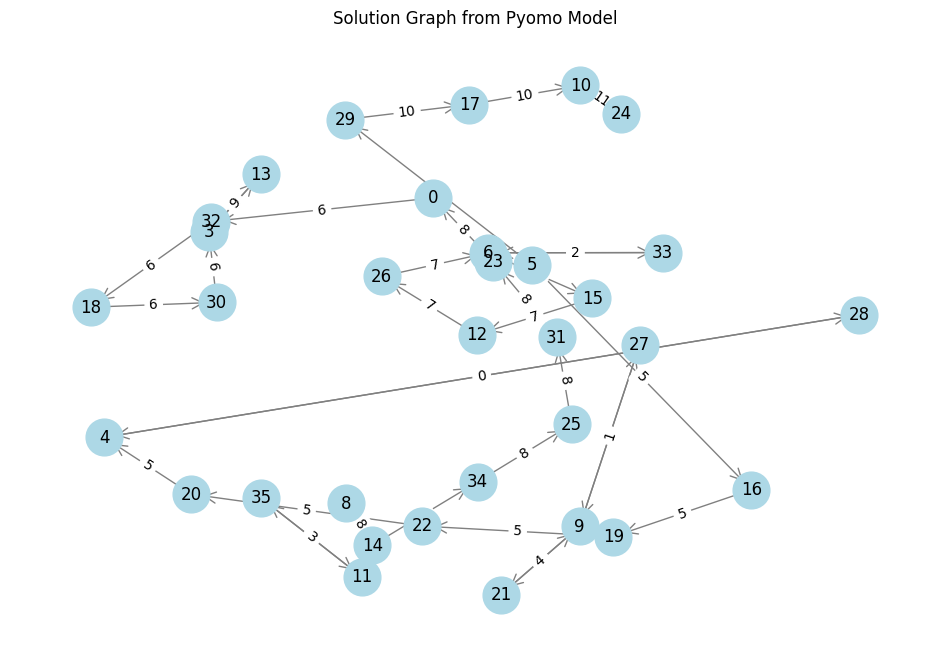

All routes have been exported to all_vehicle_routes_2024-12-07_03-47-24.csv.
Nodes in the graph: [0, 32, 3, 13, 4, 28, 5, 16, 29, 6, 15, 33, 8, 14, 9, 21, 27, 10, 24, 11, 35, 12, 26, 34, 19, 17, 18, 30, 22, 20, 23, 25, 31]


<ipython-input-33-7ce99825c2b3>:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(unique_weights))  # Use a color palette


Map saved as graph_car_2024-12-07_03-47-25.html


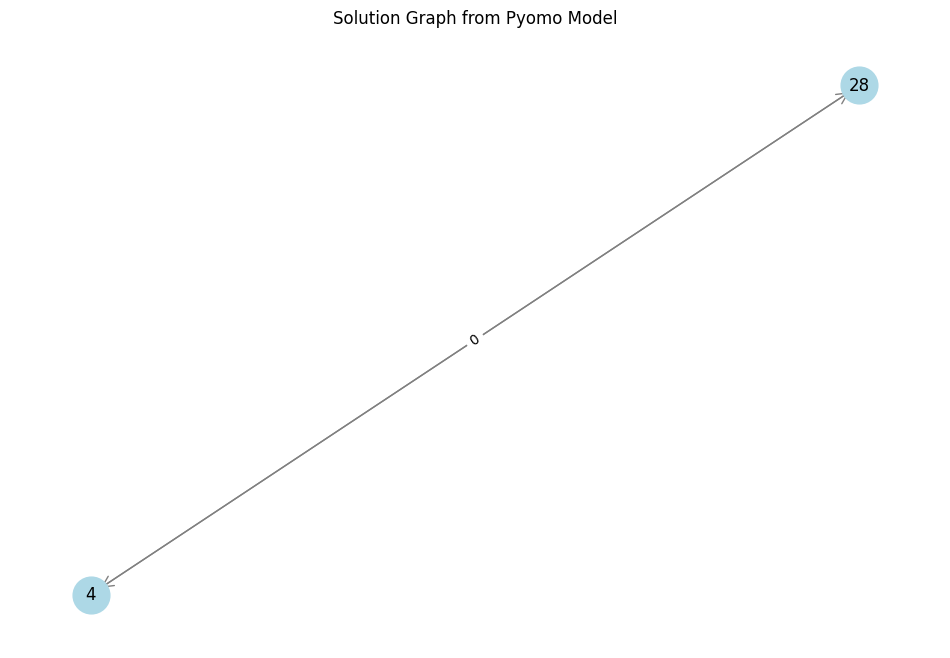

Nodes in the graph: [4, 28]
28
Demand: 25
Capacity: 131.9211396722696
Gas Car
Distance: 5.003311542227989
Range: 145.85207096486445


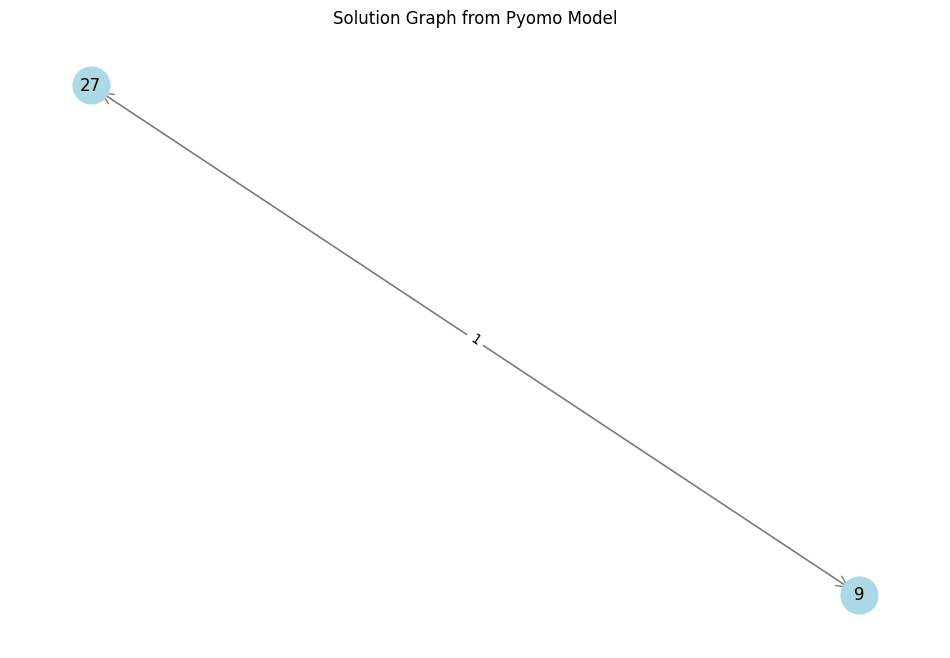

Nodes in the graph: [9, 27]
27
Demand: 10
Capacity: 135.54452491441663
Gas Car
Distance: 5.003311542227989
Range: 195.6908956922408


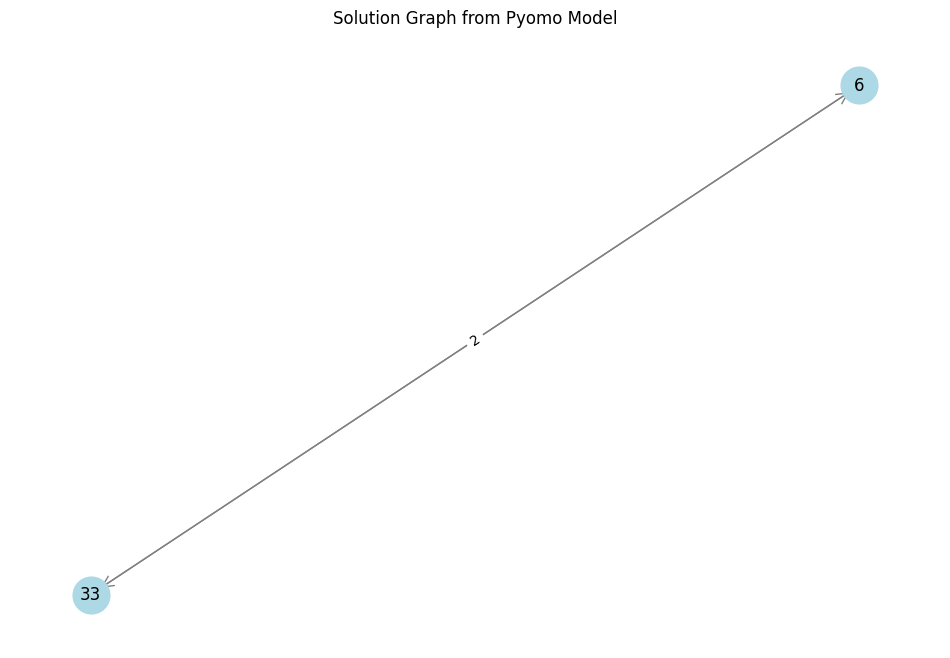

Nodes in the graph: [6, 33]
33
Demand: 18
Capacity: 114.38031900663994
Gas Car
Distance: 5.003311542227989
Range: 142.9758912915246


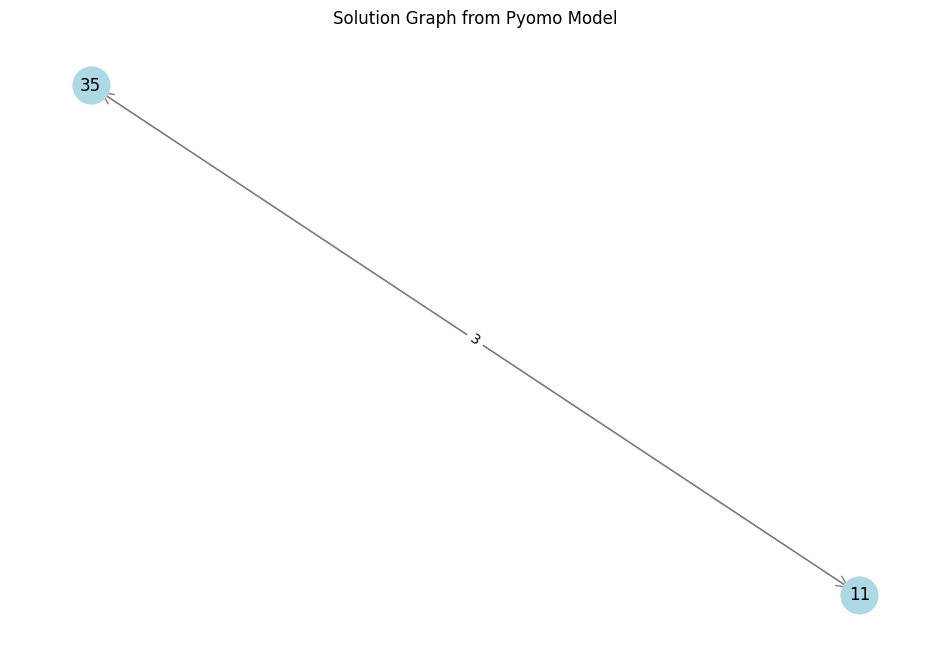

Nodes in the graph: [11, 35]
35
Demand: 11
Capacity: 157.9011075721774
Gas Car
Distance: 5.003311542227989
Range: 173.02304187458725


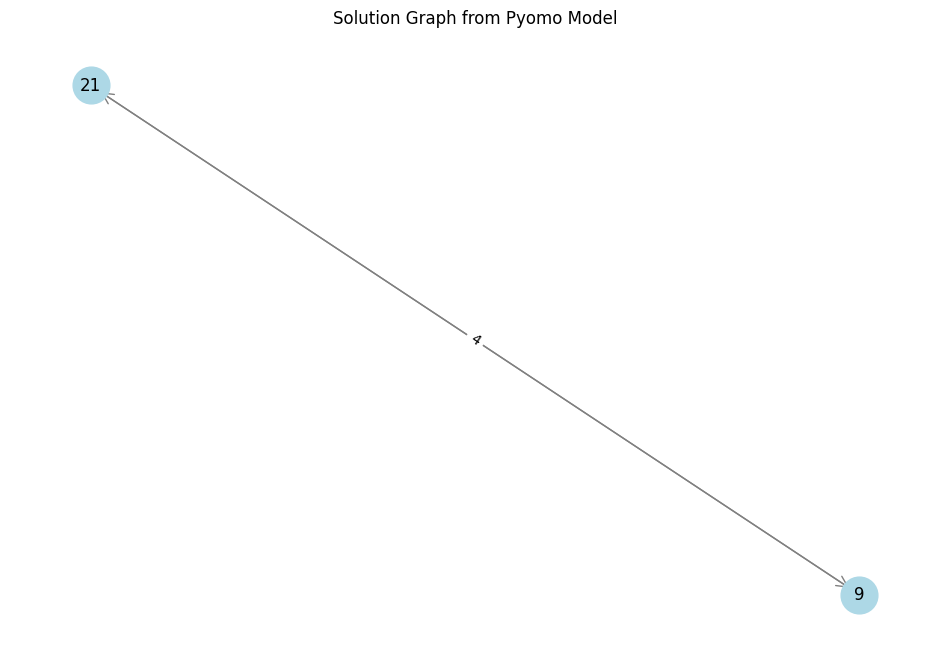

Nodes in the graph: [9, 21]
21
Demand: 15
Capacity: 86.98609179004892
EV
Distance: 5.003311542227989
Range: 1108.5120087171929


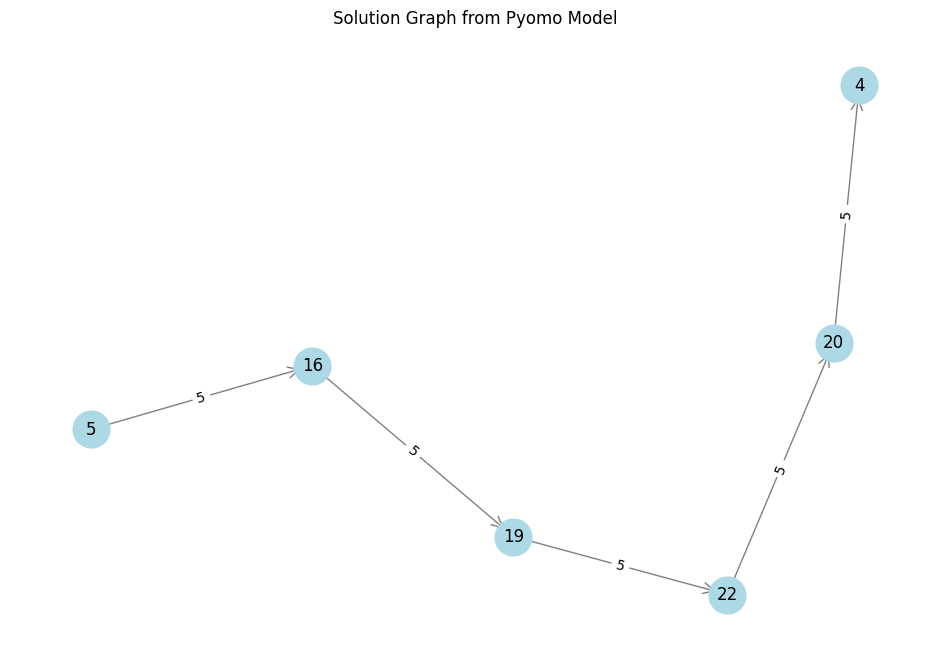

Nodes in the graph: [5, 16, 19, 22, 20, 4]
16
19
22
20
Demand: 77
Capacity: 87.10238029800072
EV
Distance: 5.003311542227989
Range: 906.8540492859486


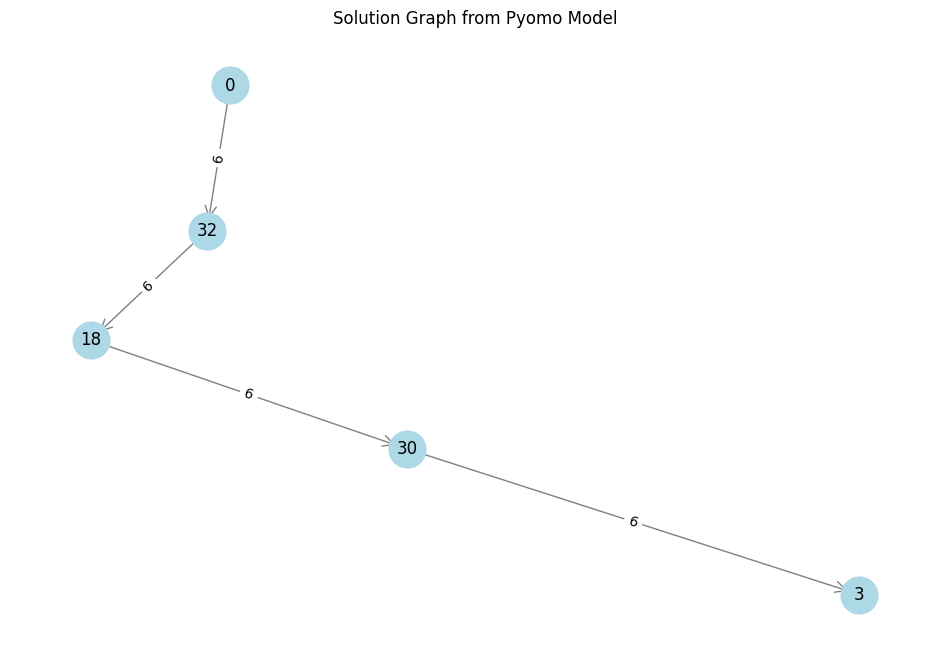

Nodes in the graph: [0, 32, 18, 30, 3]
32
18
30
Demand: 42
Capacity: 100.64567561406786
EV
Distance: 5.003311542227989
Range: 617.3439510684404


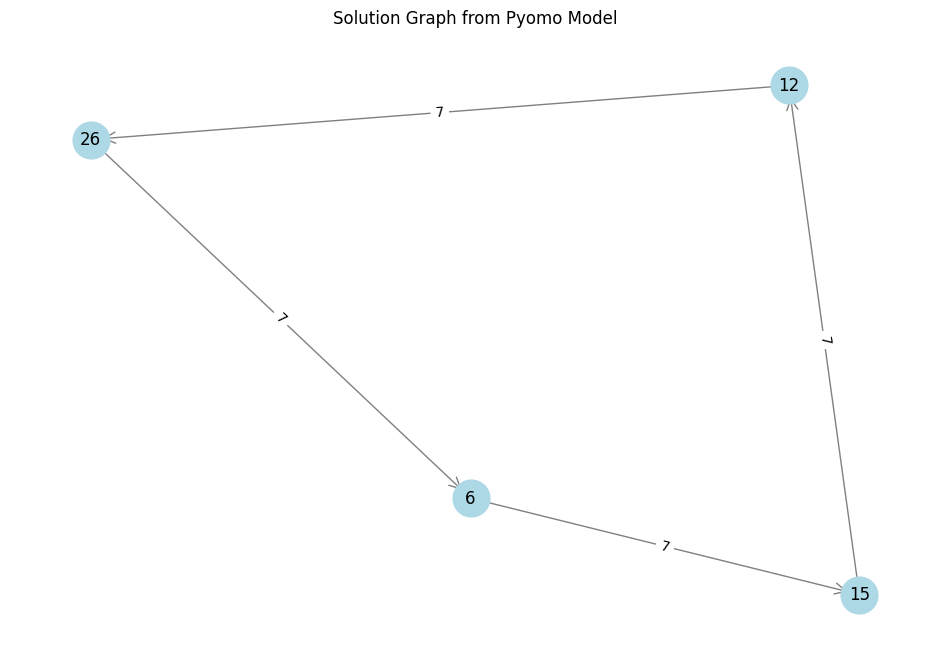

Nodes in the graph: [6, 15, 12, 26]
15
26
Demand: 32
Capacity: 62.88157761574977
EV
Distance: 5.003311542227989
Range: 887.5424941518055


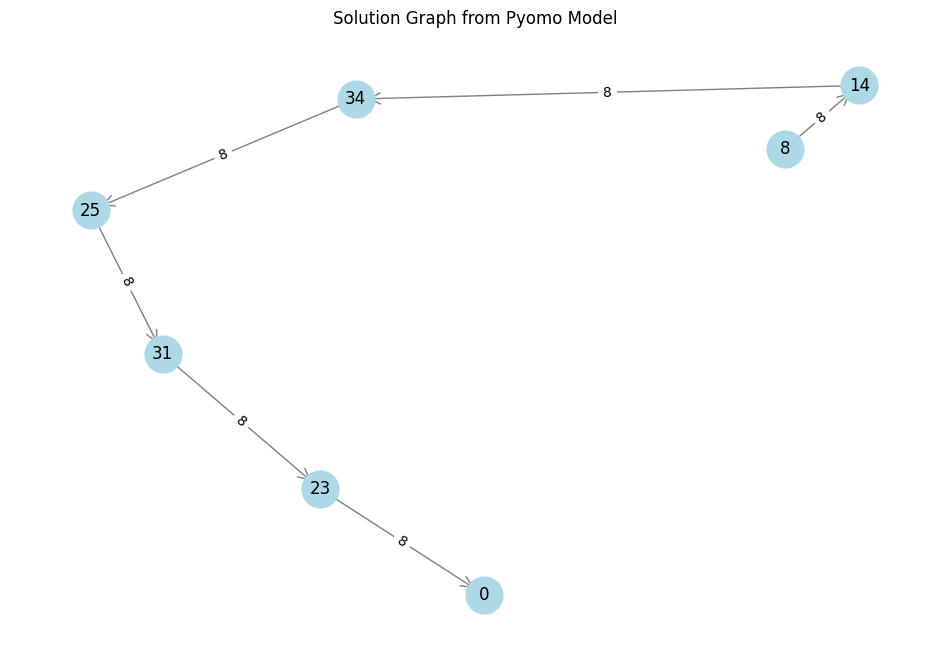

Nodes in the graph: [8, 14, 34, 23, 0, 25, 31]
14
34
23
25
31
Demand: 69
Capacity: 76.55364248957906
EV
Distance: 5.003311542227989
Range: 1062.8494665190549


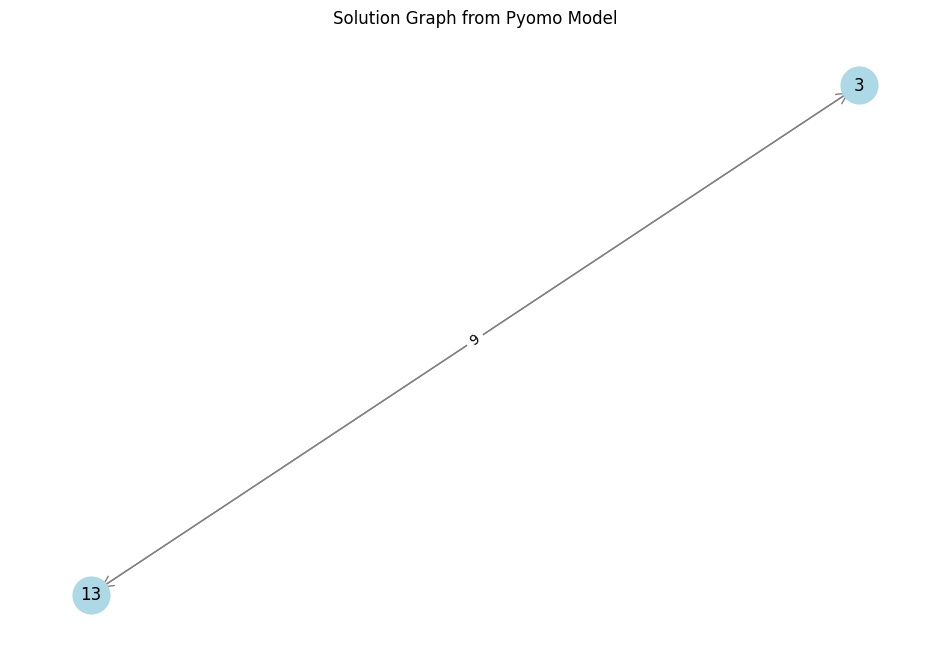

Nodes in the graph: [3, 13]
13
Demand: 15
Capacity: 20.459879622393945
drone
Distance: 7.504967313341982
Range: 10.763088895994128


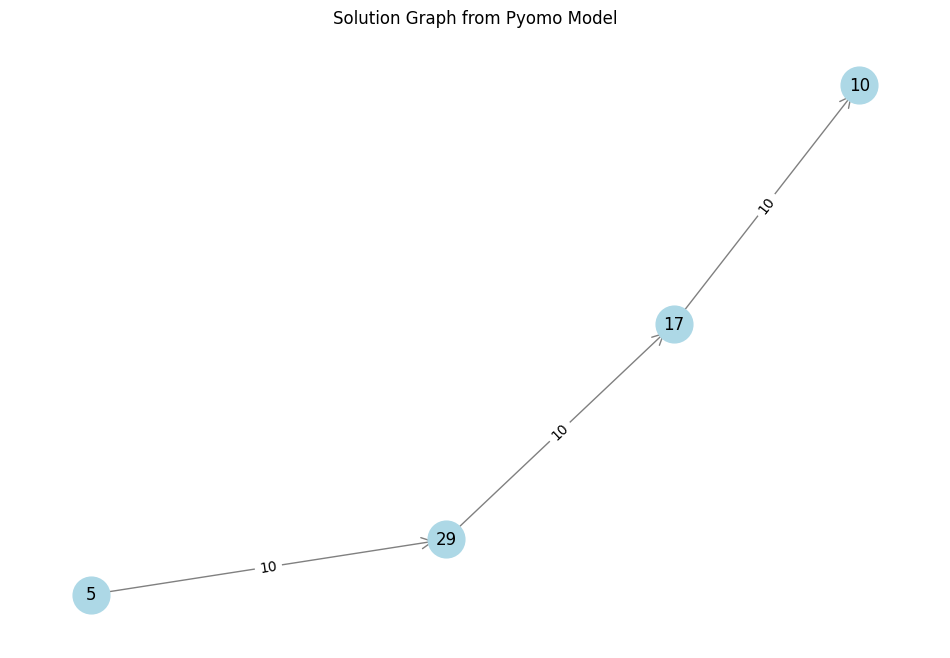

Nodes in the graph: [5, 29, 17, 10]
29
17
Demand: 29
Capacity: 32.32824384460777
drone
Distance: 7.504967313341982
Range: 14.322671098540392


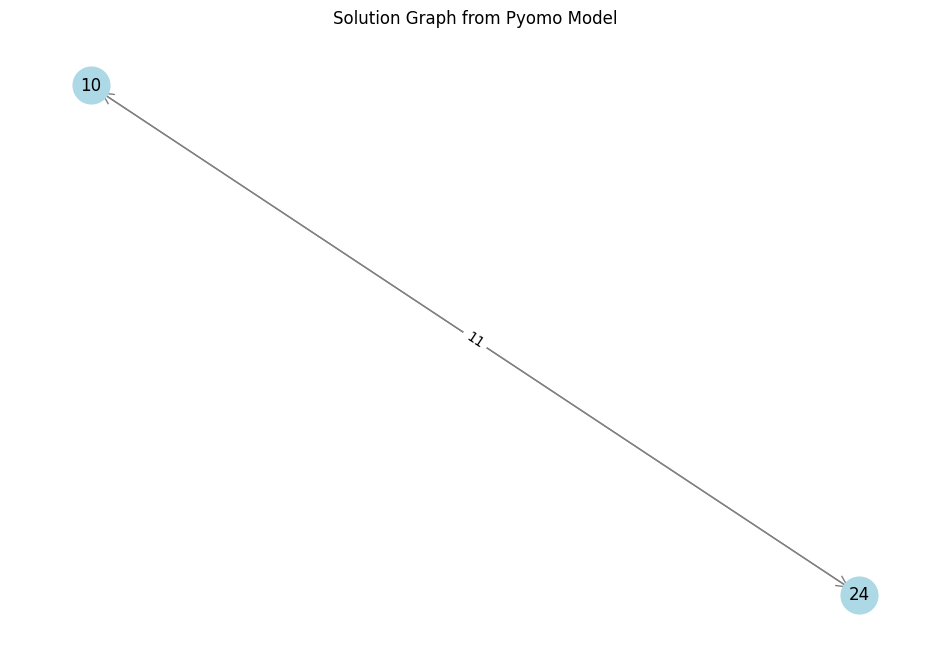

Nodes in the graph: [10, 24]
24
Demand: 21
Capacity: 25.33764102343962
drone
Distance: 7.504967313341982
Range: 10.72575544135963


In [34]:
display_base_case = display_grafs(base_case.model,data[13],data[8],data[7],data[10], data[5], data[6])
display_base_case.graf_solution()

# Caso 2

In [35]:
data2 = Data_transformation('Vehicles_case_2.csv', 'Depots_case_2.csv', 'Clients_case_2.csv', 'Nope', 2)

second_case = BaseCase(data2)

second_case.build_model()

second_case.solve_model()

HiGHS 1.8.1:   lim:time = 3600
  Warning code 1 for call Highs_run(lp())


  - termination condition: maxIterations
  - message from solver: HiGHS 1.8.1\x3a time limit, feasible solution; objective 652606.126170289; 3.66001e+06 simplex iterations; 66984 branching nodes; absmipgap=43022.2, relmipgap=0.0659237


Solver terminated with condition: maxIterations

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 6318
  Number of variables: 10764
  Sense: unknown
Solver: 
- Status: warning
  Message: HiGHS 1.8.1\x3a time limit, feasible solution; objective 652606.126170289; 3.66001e+06 simplex iterations; 66984 branching nodes; absmipgap=43022.2, relmipgap=0.0659237
  Termination condition: maxIterations
  Id: 402
  Error rc: 0
  Time: 3600.6198308467865
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 6318, 'Number of variables': 10764, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'HiGHS 1.8.1\\x3a time limit, feasible solution; objective 652606.126170289; 3.66001e+06 simplex iterations; 66984 branching nodes; absmipgap=43022.2, relmipgap=0.0659237', 'Termination condition': 'maxIterations', 'Id': 402, 'Error rc': 0, 'Time': 3600.6198308467865}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [36]:
generate_total_costs(second_case.model, data2[8], data2[3], data2[5], data2[0], data2[1], data2[2], data2[7], data2[4], data2[6])

Cost1 (Costo por asignación de producto a vehículo): 115999.99999999999
Cost2 (Costo por distancia recorrida de vehículos): 402665.6558821426
Cost3 (Costo por tiempo de uso de vehículos): 99035.9171565667
Cost4 (Costo por recarga y gasolina): 34904.55313157956
Cost5 (Costo por mantenimiento de vehículos): 108000
Total Cost (Costo total): 760606.1261702889
El archivo CSV con los costos ha sido guardado como: costs_2024-12-07_04-49-22.csv


760606.1261702889

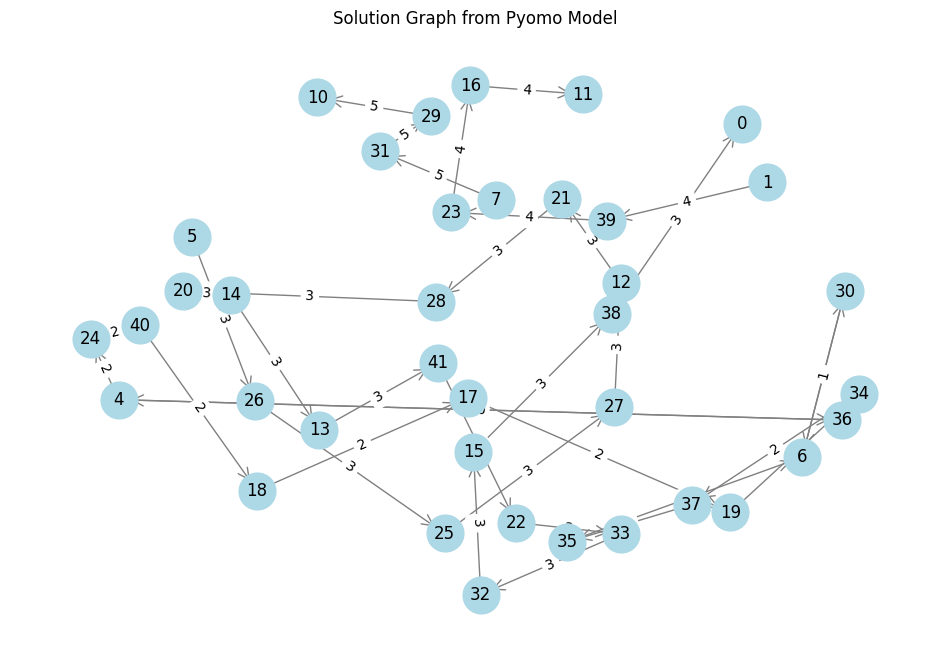

All routes have been exported to all_vehicle_routes_2024-12-07_04-49-23.csv.
Nodes in the graph: [1, 39, 4, 24, 36, 5, 26, 6, 30, 7, 31, 12, 21, 13, 41, 14, 15, 38, 16, 11, 17, 19, 18, 34, 20, 28, 22, 33, 23, 40, 25, 27, 29, 10, 32, 37, 35, 0]


<ipython-input-33-7ce99825c2b3>:111: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(unique_weights))  # Use a color palette


Map saved as graph_car_2024-12-07_04-49-23.html


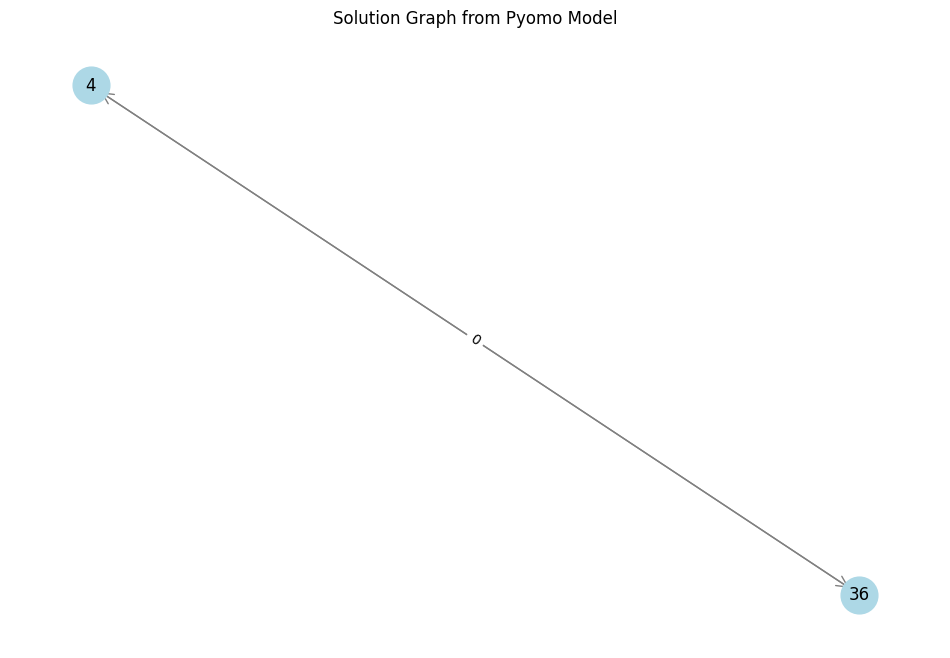

Nodes in the graph: [4, 36]
36
Demand: 10
Capacity: 131.9211396722696
Gas Car
Distance: 16.552784145142073
Range: 145.85207096486445


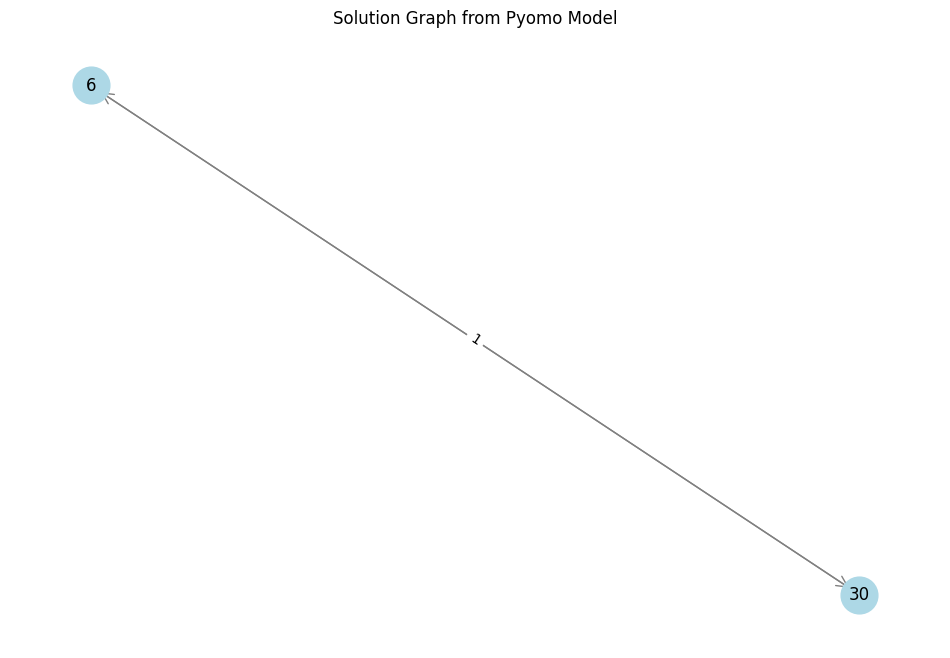

Nodes in the graph: [6, 30]
30
Demand: 10
Capacity: 135.54452491441663
Gas Car
Distance: 16.552784145142073
Range: 195.6908956922408


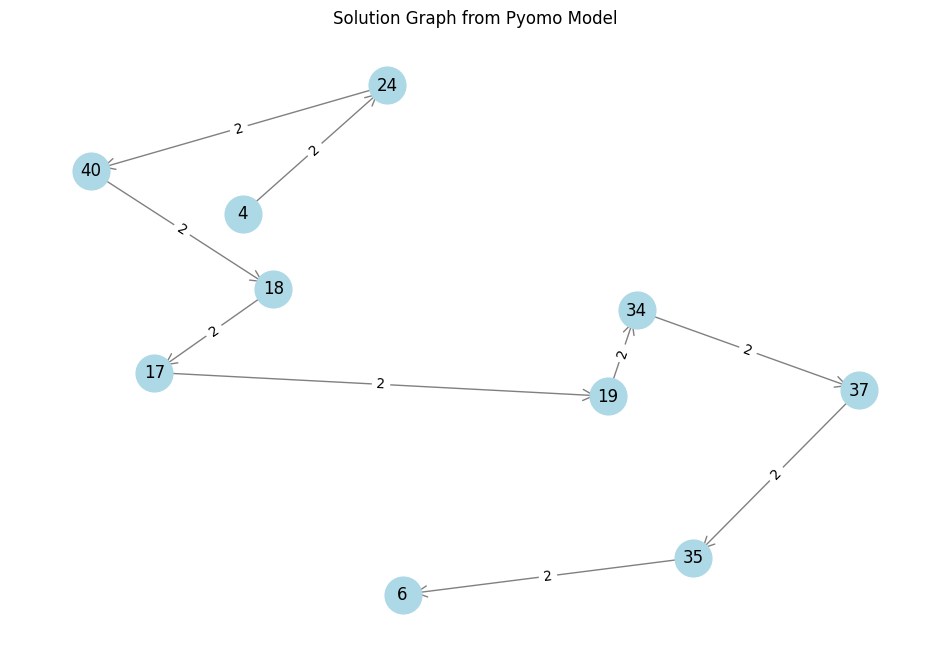

Nodes in the graph: [4, 24, 17, 19, 18, 34, 40, 37, 35, 6]
24
17
19
18
34
40
37
35
Demand: 68
Capacity: 91.50425520531196
EV
Distance: 16.552784145142073
Range: 142.9758912915246


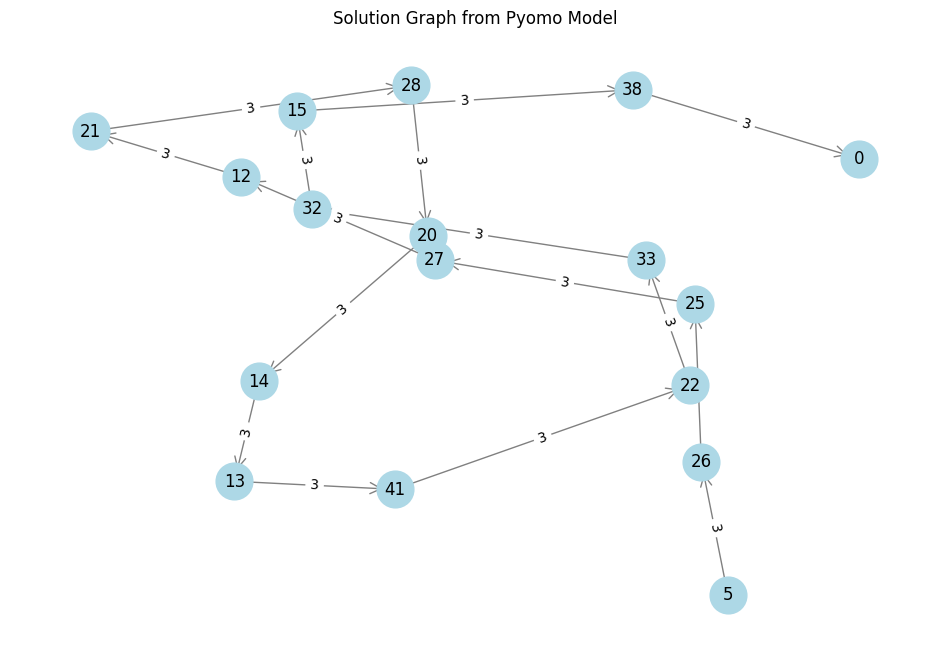

Nodes in the graph: [5, 26, 12, 21, 13, 41, 14, 15, 38, 20, 28, 22, 33, 25, 27, 32, 0]
26
21
13
41
14
15
38
20
28
22
33
25
27
32
Demand: 104
Capacity: 126.32088605774192
EV
Distance: 16.552784145142073
Range: 173.02304187458725


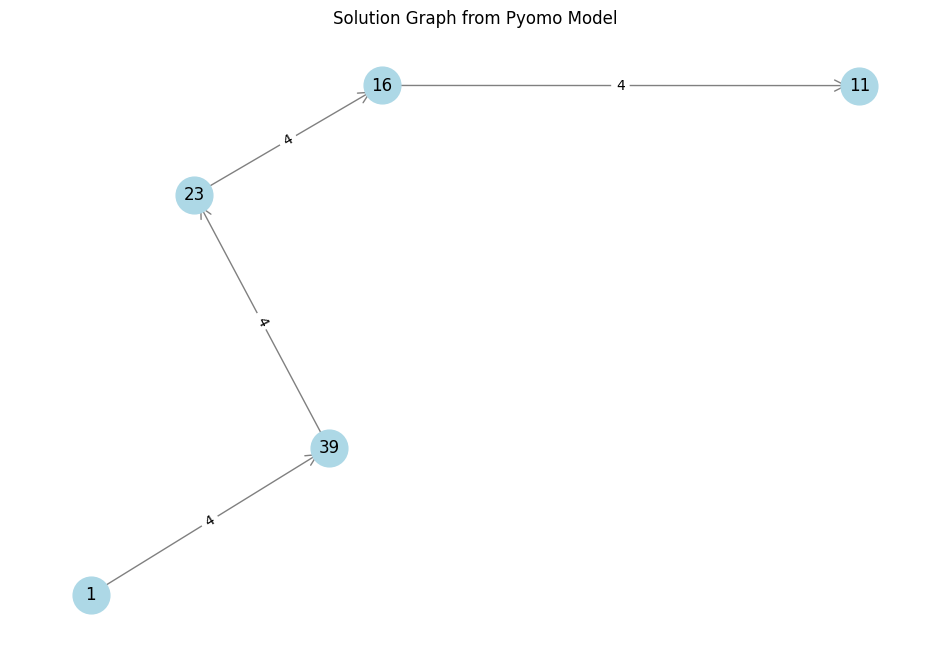

Nodes in the graph: [1, 39, 16, 11, 23]
39
16
23
Demand: 18
Capacity: 22.65262807032524
drone
Distance: 0
Range: 1108.5120087171929


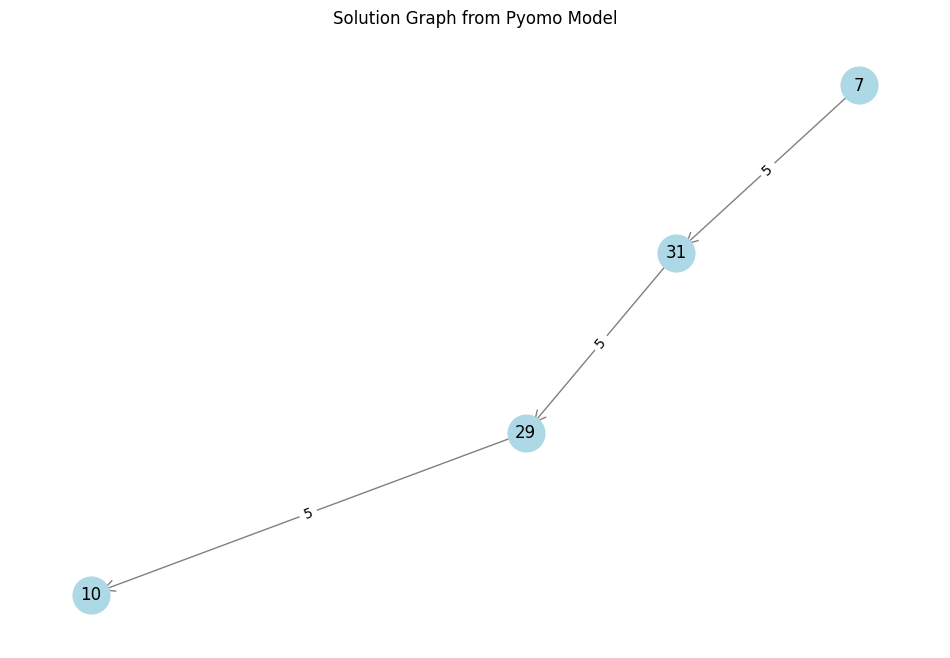

Nodes in the graph: [7, 31, 29, 10]
31
29
Demand: 17
Capacity: 22.682911535937688
drone
Distance: 0
Range: 906.8540492859486


In [37]:
display_base_case = display_grafs(second_case.model,data2[13],data2[8],data2[7],data2[10], data2[5], data2[6])
display_base_case.graf_solution()

# Análisis de Resultados

Como se pudo observar dentro de los resultados, se evidencia que el modelo cumple con todas las restricciones establecidas de manera satisfactoria, logrando así el famoso problema Multi Depot Vehicle Routing Problem. En particular, como logramos ver en la impresión individual de cada recorrido realizado por cada automóvil, cada vehículo empieza su recorrido desde algún depot y termina su recorrido en cualquier depot. Asimismo, podemos evidenciar como todos los clientes son visitados únicamente una vez por sólo un carro en particular. Además, cada vez que un automóvil llegaba a un cliente debía salir del mismo cliente. Finalmente, el vehículo no podía teletransportarse. Es decir, el modelo logró encontrar una solución óptima que permite generar caminos con sentido físico y lógico para cada uno de los automóviles, sin sub-tours ni repetición de recorridos.


En otras palabras, con nuestro modelo, logramos modelar y optimizar lo pedido por SenecaLibre. Esperamos que nuestro modelo pueda ayudar a reducir los costos y mejorar la operación de esta innovativa empresa logística. 


Contamos con tres formas de mostrar los resultados dentro del notebook: En primer lugar, un grafo completo con todos los nodos y ejes, mostrando una idea global del modelo: en este podemos ver como todos los vehículos salen de un depot y llegan a un depot, pasando por un set de clientes que ningún otro vehículo recorre. En este mismo caso podemos ver como todos los clientes son satisfechos con la demanda de producto que necesitan. En segundo lugar, un grafo en un mapa, que muestra la ubicación real de los depots y los clientes, cada uno con su respectivo color. Este nos permite tener una mejor idea de cómo están geográficamente distribuidos, permitiéndonos tener una vista menos abstracta del grafo, como lo es en el caso anteriormente mencionado. En tercer lugar, tenemos una serie de grafos que muestran el recorrido de cada vehículo en particular (cada vehículo aparece en el eje entre nodo y nodo). Bajo este, encontramos la demanda total de los clientes en ese recorrido y la capacidad de carga del vehículo en cuestión, así como la distancia total recorrida y el rango del vehículo. Así, podemos ver que el vehículo tiene suficiente capacidad para cumplir con la demanda y suficiente rango como para cumplir con el trayecto. Cabe aclarar que por practicidad de código y representación, cada nodo de cada grafo es nombrado con el LocationID-1 de cada cliente o cada nodo. Es decir, en el primer caso, los depots van del 0 al 11 y los clientes van del 12 al 35.

Además, tenemos adjuntados tres archivos para cada caso. El primer archivo, llamadao archivo_ruta_caso_n.csv tiene las rutas del caso n. En este la primera columa es el nodo de inicio, la segunda columna es el nodo final y la tercera columa es el índice del vehículo que hace esa unión. El segundo archivo, llamado Costos_caso_n.csv tiene los costos de cada aspecto de la operación, así como el costo total. El tecer y último archivo, llamado graph_map_case_n.html es la versión en página web del mapa con todos los depots y clientes mencionado en el párrafo anterior. 

En general, se evidencian unos costos satisfactorios en ambos casos, pues estos están en un rango aceptable. Ahora bien, después de muchas revisiones y correcciones, nos dimos cuenta que podrían llegar a haber casos más óptimos (con menor costo).  En particular, nuestro modelo hace obligatorio el uso de todos los vehículos, por lo que podría existir un modelo de menor costo en el que no se usen todos los vehículos disponibles.


En conclusión, se logró un modelo que cumple con todas las restricciones esperadas, y arroja un costo total dentro de rangos aceptables, incluso cuando este considera obligatorio el uso de todos los vehículos. Se hizo un esfuerzo considerable para poder lograr los resultados de la mejor forma posible, y mostrarlos de manera estética y fácil de enteder, con un código reutilizable para los siguientes casos. 